# HW2 - 2021 (Daniil Zaikin 45297780)

[Github Repo](https://github.com/XxX-Daniil-underscore-Zaikin-XxX/Daniil-Zaikin-2504-2021-HW2)

## Question 1

```bash
#!/bin/bash
mkdir hw2_q1
cd hw2_q1/
pwd
# /c/Users/Daniil/Documents/Uni Shenanigans/MATH2504/HW2/q1/hw2_q1
echo "Dan"
# Dan
echo "Dan" > my_name.txt
cat my_name.txt
# Dan
ls -lh
# total 1.0K
# -rw-r--r-- 1 Daniil 197121 4 Aug 20 11:21 my_name.txt
cp my_name.txt my_name2.txt
mkdir people
mv my_name2.txt people/Dan_Zaikin.txt
echo "Charlie" > people/Charles_Parker.txt
echo "Buddy" > people/Bernard_Rich.txt
echo "Lionel" > people/Lionel_Hampton.txt
cd people/
mv Dan_Zaikin.txt ../Dan_Zaikin.txt
mv Charles_Parker.txt "/c/Users/Daniil/Documents/Uni Shenanigans/MATH2504/HW2/q1/hw2_q1/Charles_Parker.txt"
ls -lha
# total 7.0K
# drwxr-xr-x 1 Daniil 197121 0 Aug 20 11:40 .
# drwxr-xr-x 1 Daniil 197121 0 Aug 20 11:38 ..
# -rw-r--r-- 1 Daniil 197121 6 Aug 20 11:40 .Bernard_Rich.txt
# -rw-r--r-- 1 Daniil 197121 6 Aug 20 11:29 Bernard_Rich.txt
# -rw-r--r-- 1 Daniil 197121 7 Aug 20 11:36 Lionel_Hampton.txt
rm -rf ./{*,.*}
# rm: refusing to remove '.' or '..' directory: skipping './.'
# rm: refusing to remove '.' or '..' directory: skipping './..'
rmdir people
```

## Question 2

In [11]:
using HTTP, JSON, DataFrames, CSV


"""
Returns total num of escaped chars and lines for any cell, including any outputs
"""
function get_cell_counts_shared(cell)
    char_total, lines_total = 0, 0
    for line in cell["source"]
        char_total += length(String(line))
    end

    # Count outputs if they exist
    if haskey(cell, "outputs")
        char_outputs, lines_outputs = get_counts_outputs(cell["outputs"])
        char_total += char_outputs
        lines_total += lines_outputs
    end

    lines_total += length(cell["source"])
    return char_total, lines_total
end


"""
Returns number of escaped chars and lines from an array of outputs. It considers only the following:
 - The `text` portion of an `stdout` output
 - A `text/plain` portion of a `data` output
"""
function get_counts_outputs(outputs)
    char_total, line_total = 0, 0

    # Loops through lines, checks if keys exist, add to counts if they do
    for output in outputs
        if haskey(output, "name") && output["name"] == "stdout"
            for line in output["text"]
                char_total += length(line)
            end
            line_total += length(output["text"])
        elseif haskey(output, "data") && haskey(output["data"], "text/plain")
            for line in output["data"]["text/plain"]
                char_total += length(line)
            end
            line_total += length(output["data"]["text/plain"])
        end
    end
    return char_total, line_total
end

"""
Returns array of counts for #, ##, ###, and #### (respectively) in a cell.
"""
function get_cell_counts_markdown(cell)
    count = zeros(Int32, 4)
    for line in cell["source"]
        # Loops through each index of the above array, also using it to count the number of # in a row
        for i in eachindex(count)
            # Considers a # surrounded by non-#es a match. Also takes into account BoL and EoL.
            count[i] += length(collect(m.match for m in eachmatch(Regex("^#{$i}[^#]|[^#]#{$i}[^#]|[^#]#{$i}^"), String(line))))
        end
    end
    return count
end

"""
Returns array of counts for `return`, `for`, `if`, and `using` (respectively) in a cell
"""
function get_cell_counts_code(cell)
    matches = ["return", "for", "if", "using"]
    count = zeros(Int32, 4)
    for line in cell["source"]
        # Loop through array of matches, add each match to the count
        for i in eachindex(matches)
            count[i] += length(collect(m.match for m in eachmatch(Regex(matches[i]), String(line))))
        end
    end
    return count
end

"""
Returns a formatted, processed row representing a markdown cell
"""
function process_cell_markdown(cell_number, markdown_cell)
    return [cell_number, get_cell_counts_shared(markdown_cell)..., get_cell_counts_markdown(markdown_cell)...]
end

"""
Returns a formatted, processed row representing a code cell
"""
function process_cell_code(cell_number, code_cell)
    return [cell_number, get_cell_counts_shared(code_cell)..., get_cell_counts_code(code_cell)...]
end

"""
Iterates through all given cells, formats the markdown and code cells into two separate DataFrames, returns them.
"""
function process_cells_all(all_cells)
    markdown_df = DataFrame(cell_number = Int[], character_count = Int[], line_count = Int[], one_hash = Int[], two_hash = Int[], three_hash = Int[], four_hash = Int[])
    code_df = DataFrame(cell_number = Int[], character_count = Int[], line_count = Int[], returns = Int[], fors = Int[], ifs = Int[], usings = Int[])
    for i in 1:lastindex(all_cells)
        cell = all_cells[i]
        if cell["cell_type"] == "markdown"
            push!(markdown_df, process_cell_markdown(i, cell))
        elseif cell["cell_type"] == "code"
            push!(code_df, process_cell_code(i, cell))
        end
    end
    return markdown_df, code_df
end


# Basic request - no need to pull out into a function

r = HTTP.request("GET", "https://raw.githubusercontent.com/yoninazarathy/ProgrammingCourse-with-Julia-SimulationAnalysisAndLearningSystems/main/practicals_jupyter/practical_B_julia_essentials.ipynb")
notebook_json = JSON.parse(String(r.body))


# Print the summary (with the help of an occasional inline)

println("Total number of cells: " * string(length(notebook_json["cells"])))

code_cells_count = count(cell->(cell["cell_type"] == "code"), notebook_json["cells"])
println("Number of code cells: " * string(code_cells_count))

println("Number of markdown cells: " * string(count(cell->(cell["cell_type"] == "markdown"), notebook_json["cells"])))

code_cells_nooutput_count = count(cell->(cell["cell_type"] == "code" && length(cell["outputs"]) == 0), notebook_json["cells"])
println("Number of code cells w/o output: " * string(code_cells_nooutput_count))
println("Number of code cells w/ output: " * string(code_cells_count - code_cells_nooutput_count))


"""
Quick function that takes a list of cells and iterates through their outputs, returning a somewhat comprehensive list of keys
"""
function total_keys_in_outputs(cells)
    unique_keys = Set()
    for cell in cells
        if haskey(cell, "outputs")
            for output in cell["outputs"]
                union!(unique_keys, Set(keys(output)))
                for key in keys(output)
                    if isa(output[key], Dict)
                        union!(unique_keys, Set(keys(output[key])))
                    end
                end
            end
        end
    end
    return unique_keys
end


# It always worried me whether I missed an edge case in the outputs - so, this is my chosen 'extra summary'

println("Number of unique keys present in output fields: " * string(length(total_keys_in_outputs(notebook_json["cells"]))))

# Process cells, chuck em into the csvs with proper formatting

markdown_df, code_df = process_cells_all(notebook_json["cells"])

CSV.write("markdown_summary.csv", markdown_df; header = ["cell_number", "character_count", "line_count", "#", "##", "###", "####"])

CSV.write("code_summary.csv", code_df; header = ["cell_number", "character_count", "line_count", "return", "for", "if", "using"])


# Read the files back, then print them out with decent formatting
markdown_csv, code_csv = CSV.File("markdown_summary.csv"; limit=4, header=0) |> DataFrame, CSV.File("code_summary.csv"; limit=4, header=0) |> DataFrame
println(markdown_csv)
println(code_csv)

Total number of cells: 60
Number of code cells: 33
Number of markdown cells: 27
Number of code cells w/o output: 21
Number of code cells w/ output: 12
Number of unique keys present in output fields: 8
4×7 DataFrame
 Row │ Column1      Column2          Column3     Column4  Column5  Column6  Column7 
     │ String       String           String      String   String   String   String  
─────┼──────────────────────────────────────────────────────────────────────────────
   1 │ cell_number  character_count  line_count  #        ##       ###      ####
   2 │ 1            518              9           2        1        0        0
   3 │ 2            77               2           0        0        1        0
   4 │ 3            12               1           0        0        1        0
4×7 DataFrame
 Row │ Column1      Column2          Column3     Column4  Column5  Column6  Column7 
     │ String       String           String      String   String   String   String  
─────┼─────────────────────────

## Question 3

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            1.50s / 97.9%            177MiB / 97.5%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 atan function: cds         1    318ms  21.6%   318ms   28.2MiB  16.4%  28.2MiB
 atan function: fds         1    313ms  21.3%   313ms   16.6MiB  9.62%  16.6MiB
 atan function: cvm         1    281ms  19.1%   281ms   49.8MiB  29.0%  49.8MiB
 exponent function:...      1    110ms  7.48%   110ms   9.63MiB  5.60%  9.63MiB
 exponent function:...      1    105ms  7.17%   105ms   17.1MiB  10.0%  17.1MiB
 sine function: cds         1   92.9ms  6.33%  92.9ms   16.8MiB  9.78%  16.8MiB
 exponent function:...      1   87.9ms 

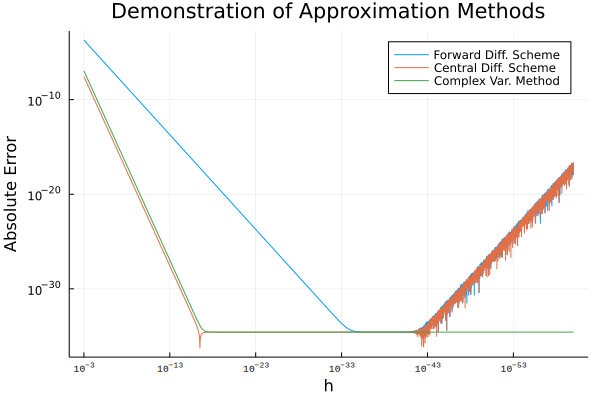

In [12]:
using Plots, DataFrames, StatsPlots, TimerOutputs

"""
Initialise the basics to avoid massive, incomprehensible globs of code
"""

function fds(func, x, h)
    return (func(x + h) - func(x))/(h)
end

function abs_error(func, x, h, approx_func, accur_value)
    return abs(accur_value - approx_func(func, BigFloat(x), BigFloat(h)))
end

function cds(func, x, h)
    return (func(x + h/2) - func(x - h/2))/(h)
end

function cvm(func, x, h)
    return imag(func(complex(x, h))/h)
end


# *avoid*, not *remove*
sine_set = (x->(sin(x^2)), BigFloat(0.5), big"0.968912421710644784144595449494")
e_set = (x->(ℯ^x), BigFloat(1), ℯ)
atan_set = (x -> (atan(x)/(1 + ℯ^(-x^2))), BigFloat(2), big"0.2746237281548575890153809496775478")


# Test the performance of each approximation for each function

performance_testing_range = map(x->(10.0^(-x)), 3.0:0.01:60)
to = TimerOutput()

optimal_value_df = DataFrame(function_name=String[], approximation_method=String[], optimal_h=BigFloat[], minimal_difference=BigFloat[]) # Sprinkling BigFloat across this task like car batteries into the ocean (I have no idea what I'm doing)

for func_set in [(atan_set, "atan function"), (sine_set, "sine function"), (e_set, "exponent function")]
    for approx_method in [fds, cds, cvm]
        # Simply times how long it takes to collate all absolute errors and find their min
        @timeit to func_set[2]*": "*String(Symbol(approx_method)) begin
            b = map(h->abs_error(func_set[1][1], func_set[1][2], BigFloat(h), approx_method, func_set[1][3]), performance_testing_range)
            c = argmin(b)
        end
        push!(optimal_value_df, (func_set[2], String(Symbol(approx_method)), performance_testing_range[c], b[c]))
    end
end

println(to)
println(optimal_value_df) # there's probably a way to display the exponent at the end in the dataframe, but I don't think the exponent is that important

# Demonstrate the differences via a chart

charting_range = map(x->(10.0^(-x)), 3.0:0.01:60) # to avoid complete computer death

# Fill the DataFrame with data points for each approximation
df = DataFrame(a=charting_range)
approx_methods_for_df = zip('b':'d', [fds, cds, cvm])
for approx_method ∈ approx_methods_for_df
    df[!, string(approx_method[1])] = map(h->abs_error(atan_set[1], BigFloat(atan_set[2]), BigFloat(h), approx_method[2], atan_set[3]), charting_range)
end

# Plot the DataFrame
inds = (df.c .> 0) .& (df.d .> 0) .& (df.b .> 0)
@df df plot(
    :a[inds], [:b[inds] :c[inds] :d[inds]], 
    xaxis=:log10, 
    xticks=map(x->(10.0^(-x)), 3.0:10:100.0), 
    xflip=true, 
    xtickfont = font(5, "Courier"), 
    xlabel = "h", 
    ylabel = "Absolute Error", 
    yscale=:log10, 
    label = ["Forward Diff. Scheme" "Central Diff. Scheme" "Complex Var. Method"], 
    title = "Demonstration of Approximation Methods"
)

The time performance difference for each approximation method was negligible, but the Complex Variable Method appeared to use more significantly more memory. All methods seem perfectly capable of approximating a derivative.

The main difference between these methods is apparent from the graph below. As we can see, the Central Difference Scheme and the Forward Difference Scheme both 'peter out' at sufficiently small values of $h$; after reaching a certain point, the absolute difference for both of these methods begins to rise with a logarithmic trend. This is not the case for the Complex Variable Method - its absolute error continues to plummet logarithmically, then comes to a hard stop within a small range of a minimum. This hard stop remains constant, which allows one to take extremely small values of $n$ without concern for rounding errors.

## Question 4

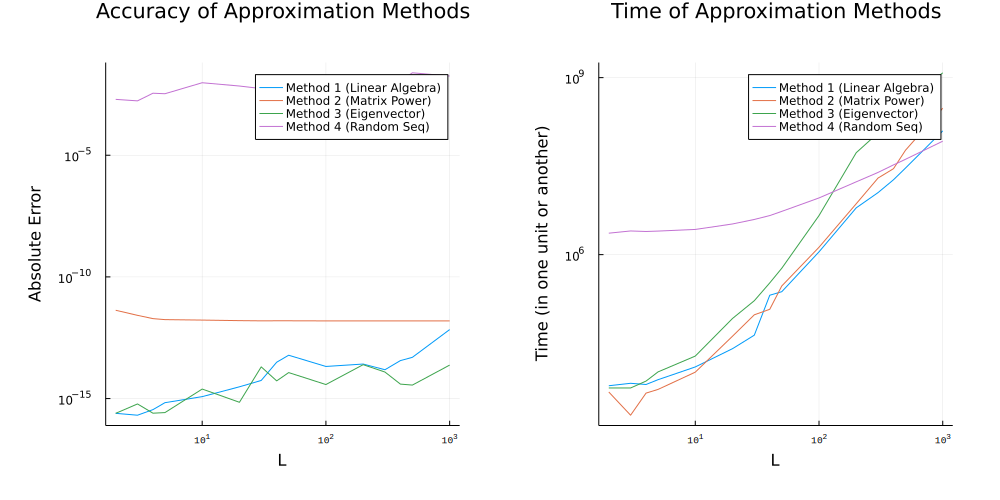

In [13]:
using LinearAlgebra, StatsBase, TimerOutputs, DataFrames, StatsPlots, BenchmarkTools, Measures

 
function structured_P(L::Int; p::Float64 = 0.45, r::Float64 = 0.01)::Matrix{Float64}
    q = 1 - p - r
    P = diagm(fill(r,L)) + diagm(-1=>fill(q,L-1)) + diagm(1 => fill(p,L-1))
    P[1,1] = 1-p
    P[L,L] = 1-q
    return P
end

structured_π(L::Int; p::Float64 = 0.45, r::Float64 = 0.01)::Vector{Float64} = begin
    q = 1 - p - r
    [(p/q)^i  for i in 1:L] * (q-p) / p / (1-(p/q)^L) #Explicit expression (birth death)
end;

# Method 1: Linear Algebra
function method_1(input_matrix, L)
    # Transpose both sides, add a row to the bottom to represent the additional requirement
    return [I - input_matrix'; ones(1, L)] \ [zeros(L); 1]
end

# Method 2: Take a high matrix power
function method_2(input_matrix, L)
    matrix_power = 10^5 # arbitrary
    # Return the first column - the 'j' doesn't matter
    return (input_matrix^(matrix_power))[1, :]
end

# Method 3: Eigen trickery
function method_3(input_matrix, L)
    eigens = eigen(input_matrix')
    correct_vector = eigens.vectors[:, findfirst(isapprox(1), eigens.values)]
    return correct_vector * UniformScaling(1 / sum(correct_vector))
end

# Method 4: Random sample
function method_4(input_matrix, L)
    repeats = 10^5 # arbitrary
    states = 1:L
    current_value = rand(states)
    chain = zeros(L) # we don't need the order, just the counts
    for i in 1:repeats
        # Take a weighted sample based on the current state
        current_value = sample(states, Weights(view(input_matrix, current_value, :)))
        chain[current_value] += 1
    end
    # Apply the 1/n
    return map(x->x/repeats, chain)
end

# The L's given by the task
L_given = [2:5..., 10:10:50..., 100:100:500..., 1000]


# Get the benchmarks warmed up and ready to go
suite = BenchmarkGroup()
for method in [method_1, method_2, method_3, method_4]
    suite[String(Symbol(method))] = BenchmarkGroup()
end


# Prepare data structures
norms_df = DataFrame(a=L_given)
approx_methods_for_df = zip('b':'e', [method_1, method_2, method_3, method_4])

for approx_method ∈ approx_methods_for_df
    # Benchmark each L for each function, add it to suite
    for L in L_given
        suite[String(Symbol(approx_method[2]))][L] = @benchmarkable $(approx_method[2])(structured_P($L), $L)
    end

    # Put the error into the df for plotting
    norms_df[!, string(approx_method[1])] = map(L->norm(approx_method[2](structured_P(L), L) - structured_π(L)), L_given)
end

# Run our thing
results = run(suite, seconds = 2, samples = 5)


# Plot the DataFrames

# Make sure none of the values break the graph
inds = (norms_df.c .> 0) .& (norms_df.d .> 0) .& (norms_df.b .> 0) .& (norms_df.e .> 0)
# Plot the absolute errors of each method
n_plot = @df norms_df plot(
    :a[inds], [:b[inds] :c[inds] :d[inds] :e[inds]], 
    xaxis=:log10,
    xtickfont = font(5, "Courier"), 
    xlabel = "L", 
    ylabel = "Absolute Error", 
    yscale=:log10, 
    label = ["Method 1 (Linear Algebra)" "Method 2 (Matrix Power)" "Method 3 (Eigenvector)" "Method 4 (Random Seq)"], 
    title = "Accuracy of Approximation Methods"
)

# Prepare the benchmarks for plotting (load their median times into a dataframe)
benchmarks_df = DataFrame(L=L_given)
for method in keys(results)
    benchmarks_df[!, String(Symbol(method))] = map(L->median(results[method][L]).time, L_given)
end

# Plot the benchmarks
bm_plot = @df benchmarks_df plot(
    :L, [:method_1 :method_2 :method_3 :method_4], 
    xaxis=:log10,
    xtickfont = font(5, "Courier"), 
    xlabel = "L", 
    ylabel = "Time (in one unit or another)", # either milliseconds or microseconds - it's the vibe that counts
    yscale=:log10, 
    label = ["Method 1 (Linear Algebra)" "Method 2 (Matrix Power)" "Method 3 (Eigenvector)" "Method 4 (Random Seq)"], 
    title = "Time of Approximation Methods"
)

# Release the Alpha Plot into the wild
display(plot(n_plot, bm_plot, margin = 10mm, size = (1000, 500)))

## Question 6

### 5a - 5b

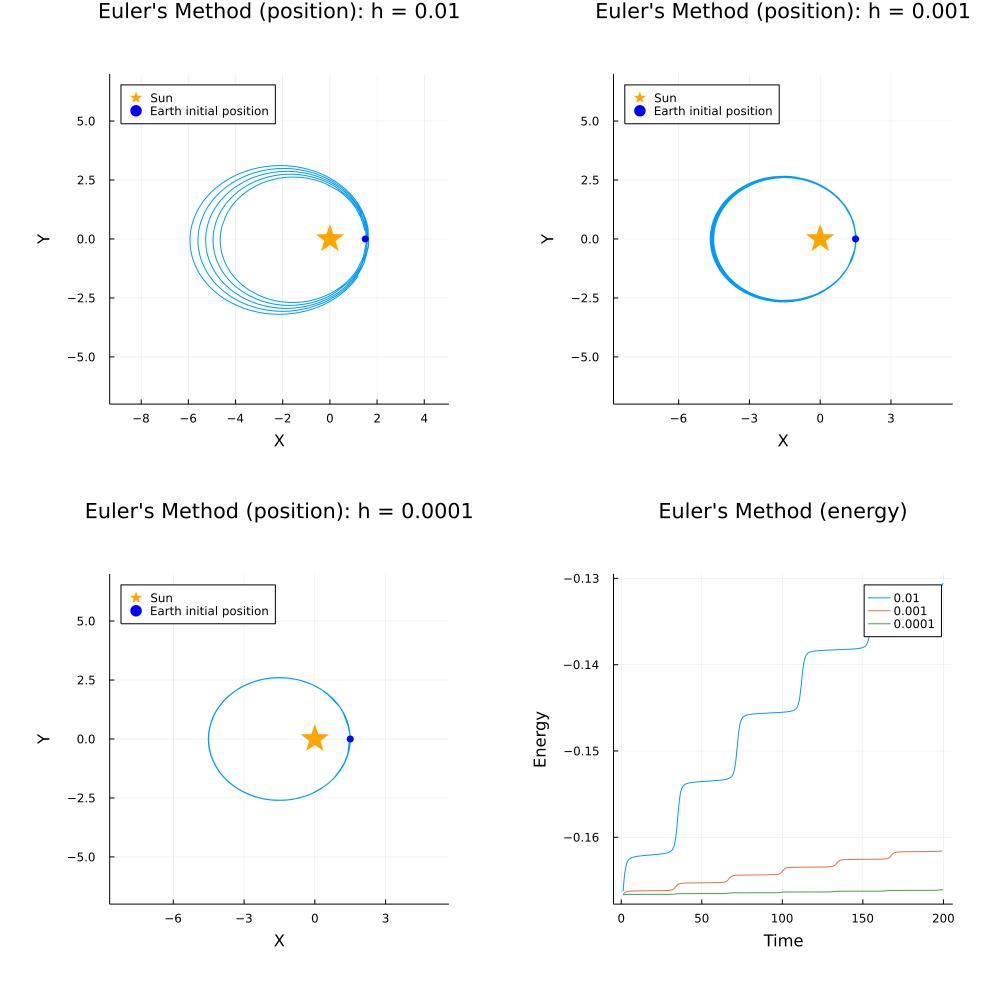

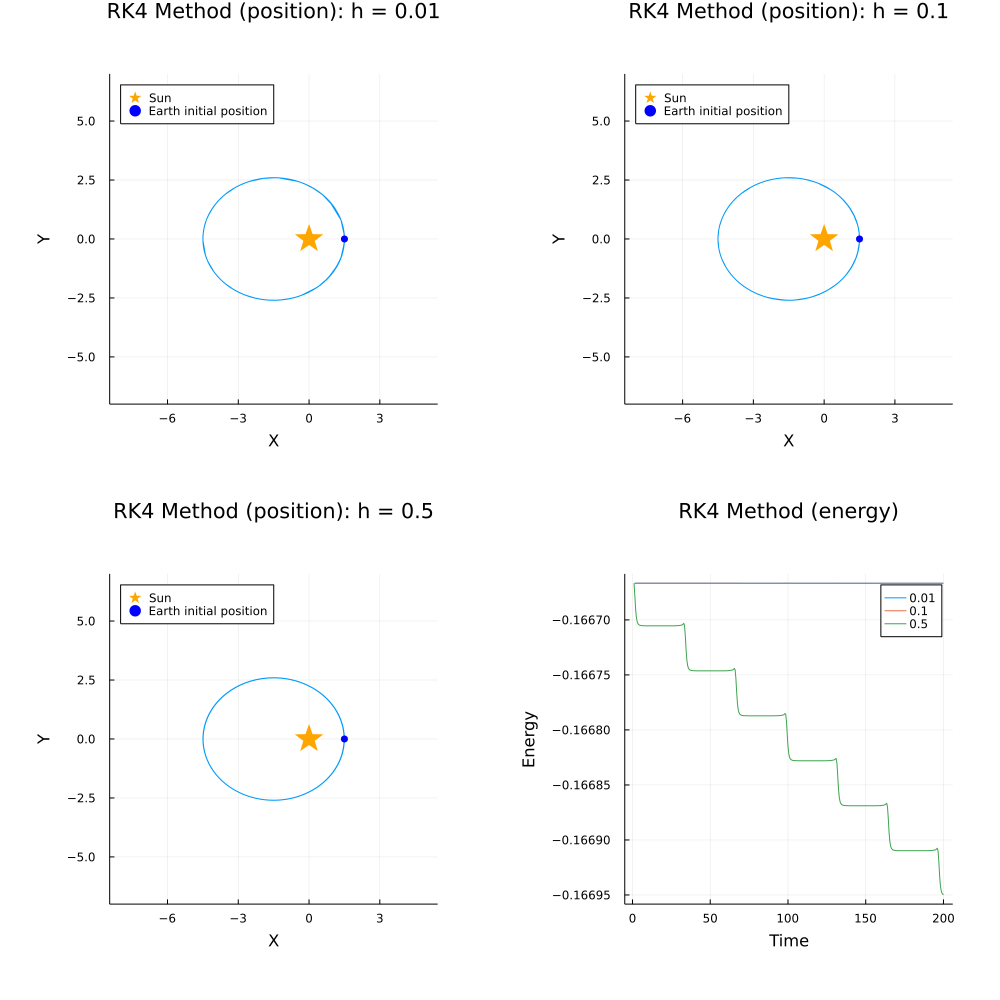

In [14]:
using Plots, Measures, HTTP, Serialization, Random

#These four convenience functions extract the state variable from the state vector
#It is assumed the layout of the vector u is u = [v_x, v_y, x, y]
state_v_x(u::Vector{Float64}) = u[1]
state_v_y(u::Vector{Float64}) = u[2]
state_x(u::Vector{Float64}) = u[3]
state_y(u::Vector{Float64}) = u[4]

"""
Modified version of the given function. Takes a Vector of tuples of (Float, Vector), first element being h and the second being the values corresponding to that h
"""
function plot_solutions( t::Int64, 
    u::Vector{Tuple{Float64,Vector{Vector{Float64}}}};
    title::String = "",
    label::Union{String, Bool} = false,
    show_energy = true,
    combine_positions = false) where T
    
    position_plots = [] # Storing plots
    energy_values = [] # Storing values to plot later

    # Iterates through given sets of values, does mostly the same thing as the given function
    for (h, u_vec) in u
        x, y, v_x, v_y = state_x.(u_vec), state_y.(u_vec), state_v_x.(u_vec), state_v_y.(u_vec)

        r = @. sqrt(x^2 + y^2)
        E = @. 0.5*(v_x^2 + v_y^2) - 1.0/r

        # Pushes to plot list instead of plotting outright
        push!(position_plots, plot(  reduce_data_points([x], [y])..., label = label, xlabel= "X", ylabel = "Y",
        title = title*" (position): h = $h", aspectratio=1,legend=:topleft,ylim=(-7,7)))
        scatter!([0], [0], ms=15, msw=0, c=:orange, shape =:star, label="Sun")
        scatter!([x[1]], [y[1]], ms=4, msw=0, c=:blue, shape =:circle, label="Earth initial position")
        
        # Push values without plotting
        push!(energy_values, (h, E))
    end

    # Plot all energy values all at once
    x_values_full, y_values_full = map(x->1:x[1]:t, energy_values), map(x->x[2], energy_values)
    p4 = plot(  reduce_data_points(x_values_full, y_values_full)..., xlabel = "Time", ylabel = "Energy",
    label = transpose(map(x->x[1], energy_values)), title = title*" (energy)")
    
    # Exclude the energy plot if not needed
    plots_to_plot = position_plots
    if show_energy
        push!(plots_to_plot, p4)
    end

    # Collate all plots into the apex plot
    return plot(plots_to_plot..., margin = 10mm,size=(1000,1000))
end;

"""
"Simple" function for reducing the amount of data points in a graph. Both args must be vectors of vectors.
"""
function reduce_data_points(x_values_full, y_values_full)
    x_values_truncated, y_values_truncated = [], []
    for i in eachindex(x_values_full)
        len = length(x_values_full[i])
        randsub = randsubseq(1:len, min(1000, len)/len)
        push!(x_values_truncated, x_values_full[i][randsub])
        push!(y_values_truncated, y_values_full[i][randsub])
    end
    return x_values_truncated, y_values_truncated
end

# Using the same starting values as given
h_list = map(x->10^(-x), 2.0:4.0)
t_max = 200
u_0 = [0., 1, 1.5, 0]

"""
Computes the RHS for the one body problem (the t arg has been removed)
"""
function df_dt_one_body(u::Vector{Float64})::Vector{Float64}
    M, G = 1, 1
    r = sqrt(state_x(u)^2 + state_y(u)^2)
    return [-M*G*state_x(u)/r^3, -M*G*state_y(u)/r^3, state_v_x(u), state_v_y(u)]
end;

"""
Performs euler method. f is a function which takes a single arg of same type as u_0
"""
function euler_method(f, u_0, step_size, t_vec)
    values = [u_0]
    previous = u_0
    for i in 2:length(t_vec)
        next = previous .+ step_size * f(previous)
        previous = next
        push!(values, next)
    end
    return values
end

"""
Performs RK4 method. f takes a single argument of same type as u_0
"""
function rk4_method(f, u_0, step_size, t_vec)
    values = [u_0]
    prev_value = u_0
    # Could go at it recursively, but I also don't want to make my code even more unreadable
    for i in 2:length(t_vec)
        next_value = prev_value .+ rk4_calculate_section(f, prev_value, step_size)
        push!(values, next_value)
        prev_value = next_value
    end
    return values
end

"""
Helper function for the cumbersome calculation. Args must be vectors.
"""
function rk4_calculate_section(f, current_elem, step_size)
    k_1 = f(current_elem)
    k_2 = f(current_elem .+ ((step_size/2) * k_1))
    k_3 = f(current_elem .+ ((step_size/2) * k_2))
    k_4 = f(current_elem .+ (step_size * k_3))
    return (step_size/6) * (k_1 .+ (2 .* k_2) .+ (2 .* k_3) .+ k_4)
end


# The part where the graphs get drawn
display(plot_solutions(t_max, map(h -> (h, euler_method(df_dt_one_body, u_0, h, 1:h:t_max)), h_list), title="Euler's Method"))


# The part where the computer chugs
h_best, h_worst = 0.01, 0.01 # for RK4 and Euler (respectively)
anim = @animate for i = 10:max(t_max÷100, 1):t_max
    plot_solutions(i, [(h_best, rk4_method(df_dt_one_body, u_0, h_best, 1:h_best:i)), (h_worst, euler_method(df_dt_one_body, u_0, h_worst, 1:h_worst:i))], title="Combined animation", show_energy = false)
end

# gif(anim, "tutorial_anim_fps30.gif", fps = 30)

h_list_rk4 = [0.01, 0.1, 0.5]
display(plot_solutions(t_max, map(h -> (h, rk4_method(df_dt_one_body, u_0, h, 1:h:t_max)), h_list_rk4), title="RK4 Method"))

### 5c

To begin with, the RK4 method is significantly more accurate. Even with $h=0.5$, the results far exceeded those of Euler's - and this is very clear to see from the graphs.

In terms of efficiency, it appears as if the two methods are not far seperated for this particular task. This is likely due to the relatively lightweight nature of the differential equation; with more complex examples, I can without a doubt see the RK4 method taking a more noticeable performance hit. However, the stark decrease in the required number of computations due to the ability to use a larger $h$ offsets that into negligibility - as such, it's probably going to end up being more efficient than Euler's method in a good number of cases.

### 5d

[Animatoin](https://github.com/XxX-Daniil-underscore-Zaikin-XxX/Daniil-Zaikin-2504-2021-HW2/blob/master/tutorial_anim_fps30.gif)